# **Live 4chan/mu/ Discussion Statistics** 
### Provides live stream of statistics from music board including peak usage, most popular threads and most common words

by Zachary Newman 21149116

## Parsing Music Data, Process Data, Plot Results

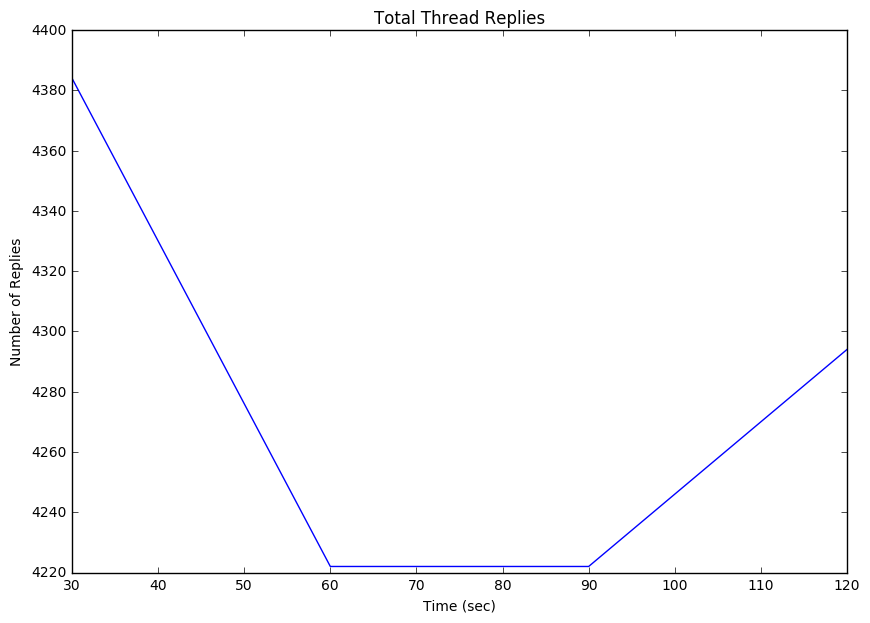

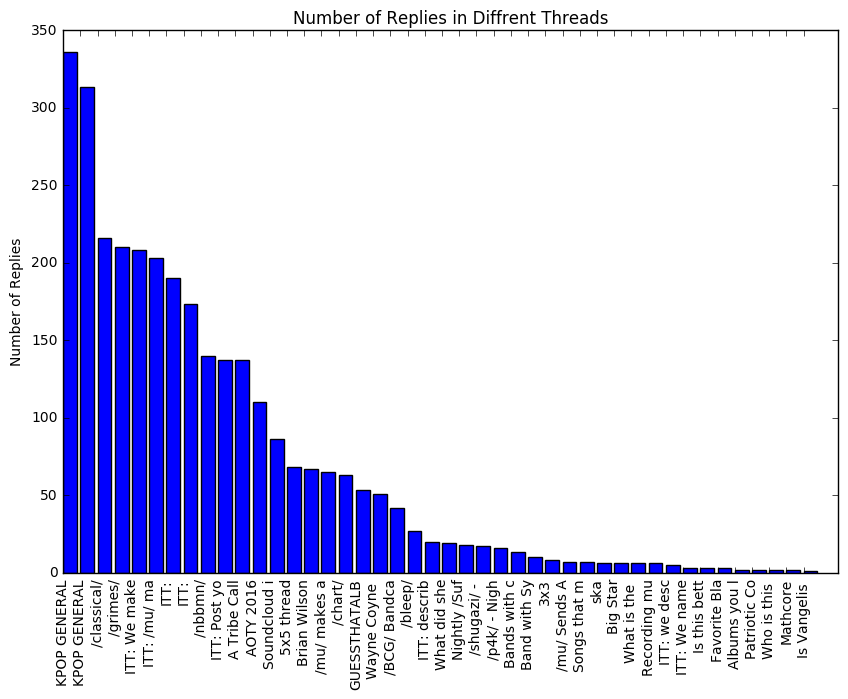

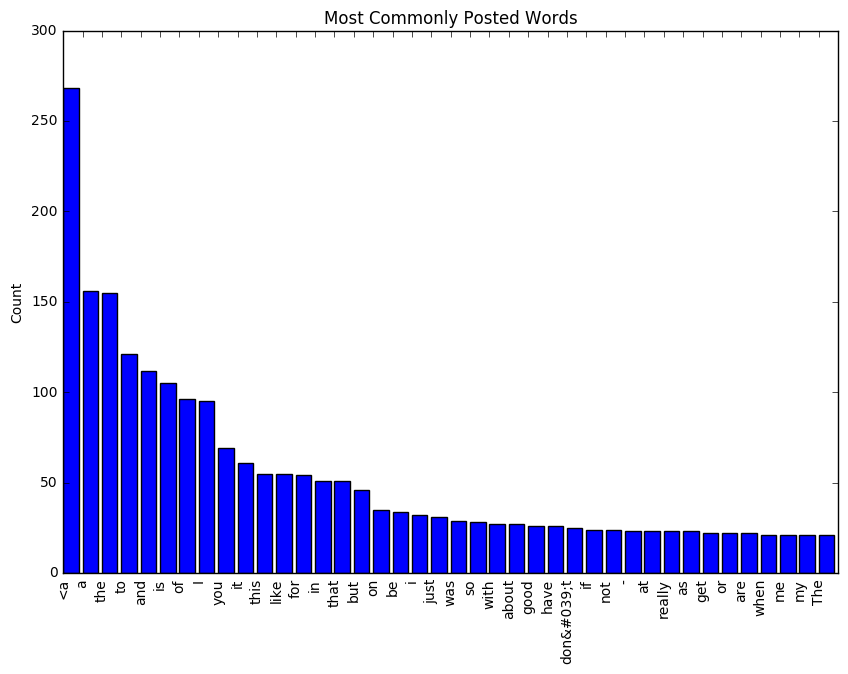

In [ ]:
import urllib2
import json
from pyspark import SparkContext
import matplotlib.pyplot as plt
import matplotlib.figure
import sched, time
import numpy
from operator import add
from IPython.display import clear_output

s = sched.scheduler(time.time, time.sleep)
x_time = 5 # sec

try:
    sc = SparkContext()
except:
    print

threads = []
totalReplies = []
x_totalReplies = []
response = None
j = None

rdd = None
fig = matplotlib.figure.Figure()
ax = fig.add_subplot(111)


def getBoardData():
    
    global threads
    global rdd
    global totalReplies
    global x_totalReplies
    global fig1
    global response
    global j
    
    try:
        threads = []
        response = urllib2.urlopen('http://a.4cdn.org/mu/catalog.json')
        html = response.read()
        j = json.loads(html)

        # break data into threads
        for i in range(1,len(j)):
            for k in range(1, len(j[i]['threads'])):
                threads.append(j[i]['threads'][k])

        rdd = sc.parallelize(threads)

        #calc total replies
        totalReplies.append(rdd.map(lambda x: x['replies']).reduce(lambda a,b: a+b))
        if not x_totalReplies:
            x_totalReplies.append(x_time)
        else:
            x_totalReplies.append(x_totalReplies[-1] + x_time)


        #calc most popular threads
        rep_sub =  rdd.filter(lambda x: x['replies'] > 0)\
                            .filter(lambda x: 'sub' in x)\
                        .map(lambda x: (x['replies'], x['sub']))\
                        .sortByKey(False)

        rep_count = rep_sub.map(lambda (x,y): x).collect()
        sub_labels = rep_sub.map(lambda (x,y): y).collect()
        sub_labels[:] = (elem[:12] for elem in sub_labels)
        xsub = range(len(rep_count))

        #calc most common thread words
        wordCounts = rdd.filter(lambda x: 'last_replies' in x)\
                        .map(lambda x: x['last_replies'])\
                        .flatMap(lambda x: x)\
                        .filter(lambda x: 'com' in x)\
                        .map(lambda x: x['com'])\
                        .map(lambda x: x.encode('ascii','ignore'))\
                        .flatMap(lambda x: x.split(" "))\
                        .map(lambda x: (x,1))\
                        .reduceByKey(lambda a,b: a+b).sortBy(lambda x: x[1],False)
        words = wordCounts.map(lambda (x,y): x).take(40)
        counts = wordCounts.map(lambda (x,y): y).take(40)
        interval = range(40)

        # plot results
        clear_output()
        plt.figure(1, figsize=(10,7))
        plt.plot(x_totalReplies, totalReplies)
        plt.title("Total Thread Replies")
        plt.xlabel("Time (sec)")
        plt.ylabel("Number of Replies")

        plt.figure(2, figsize=(10,7))
        plt.bar(xsub, rep_count)
        plt.title("Number of Replies in Diffrent Threads")
        plt.ylabel("Number of Replies")
        plt.xticks(xsub, sub_labels, rotation='vertical')

        plt.figure(3, figsize=(10,7))
        plt.bar(interval, counts)
        plt.title("Most Commonly Posted Words")
        plt.ylabel("Count")
        plt.xticks(interval, words, rotation='vertical')
        plt.show()
    except:
        print
    
    s.enter(x_time, 1, getBoardData,())
    
s.enter(0, 1, getBoardData, ())
s.run()